In [7]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB 259.2 kB/s eta 0:09:39
   ---------------------------------------- 0.1/150.0 MB 435.7 kB/s eta 0:05:45
   ---------------------------------------- 0.1/150.0 MB 652.5 kB/s eta 0:03:50
   ---------------------------------------- 0.3/150.0 MB 1.1 MB/s eta 0:02:13
   ---------------------------------------- 0.3/150.0 MB 1.1 MB/s eta 0:02:18
   ---------------------------------------- 0.5/150.0 MB 1.4 MB/s eta 0:01:47
   ---------------------------------------- 0.5/150.0 MB 1.5 MB/s eta 0:01:44
   ---------------------------------------- 0.5/150.0 MB 1.5 MB/s eta 0:01:44
   ---------------------------------------- 0.7/150.0 MB 1.6 MB/s eta 0:01:32
   ---------------------------------------- 0.8/150.0 MB 1.5 MB/s eta 0:01:41
 


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\KIIT\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
pip install textblob

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata (41 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
    --------------------------------------- 10.2/624.3 kB ? eta -:--:--
   - ------------------------------------- 20.5/624.3 kB 165.2 kB/s eta 0:00:04
   - ------------------------------------- 30.7/624.3 kB 217.9 kB/s eta 0:00:03
   -- ------------------------------------ 41.0/624.3 kB 245.8 kB/s eta 0:00:03
   ------ ------------------------------- 102.4/624.3 kB 454.0 kB/s eta 0:00:02
   -------- ----------------------------- 143.4/624.3 kB 568.9 kB/s eta 0:00:01
   --------------- ---------------------- 256.0/624.3 kB 874.6 kB/s eta 0:00:01
   -------------------------- ------------- 419.


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\KIIT\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
#1 importing libraries
#1.1 Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob

#1.2 Preprocessing & modeling
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# 2.1 data loading
df = pd.read_csv('IMDb Movies India.csv', encoding='ISO-8859-1')
print(f"Dataset shape: {df.shape}")
print("Columns:", df.columns.tolist())

Dataset shape: (15509, 10)
Columns: ['Name', 'Year', 'Duration', 'Genre', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']


In [14]:
# 3. Data Cleaning

# 3.1 Drop rows missing the target
df = df.dropna(subset=['Rating'])

# 3.2 Clean 'Duration' column
# Remove 'min' and convert to numeric
df['Duration'] = df['Duration'].str.replace('min', '').str.strip()
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

# Fill missing 'Duration' with the median
df['Duration'] = df['Duration'].fillna(df['Duration'].median())

# 3.3 Fill missing 'Votes' values
df['Votes'] = df['Votes'].fillna(0)

# 3.4 Clean the 'Year' column
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(0).astype(int)

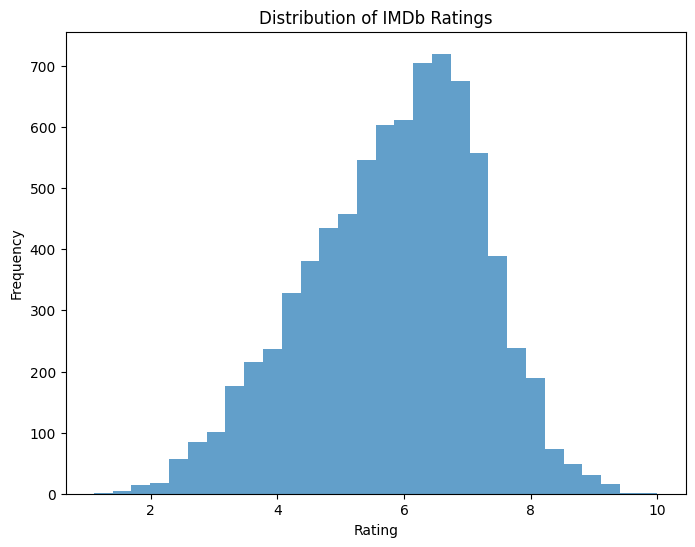

In [ ]:
#EDA

#4.1 Distribution of IMDb Ratings
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(df['Rating'], bins=30, alpha=0.7)
plt.title('Distribution of IMDb Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show() #Insight: Ratings are right-skewed, with most movies between 6–8.

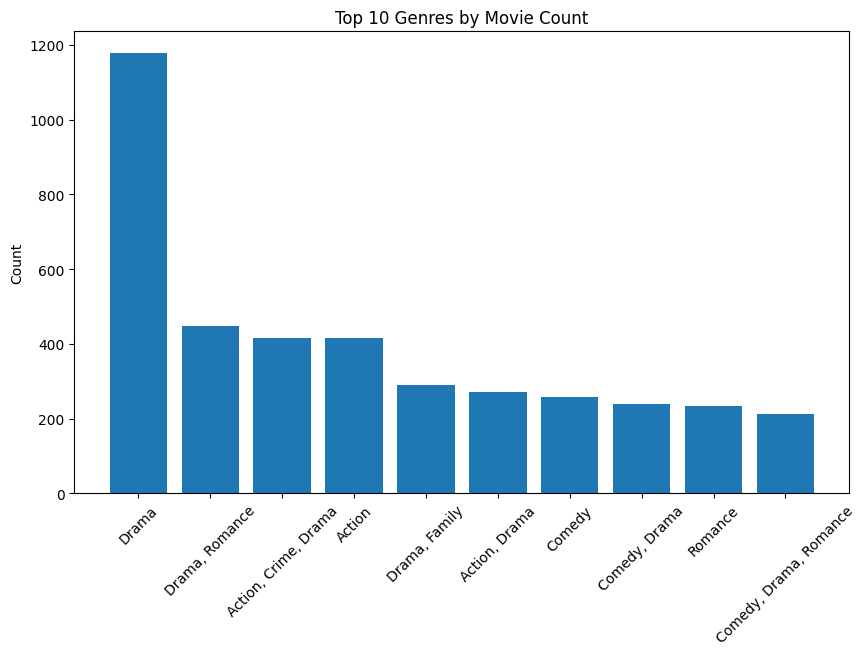

In [ ]:
#4.2 4.2 Top Genres by Movie Count
top_genres = df['Genre'].value_counts().nlargest(10)
plt.figure(figsize=(10,6))
plt.bar(top_genres.index, top_genres.values)
plt.title('Top 10 Genres by Movie Count')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show() #Insight: Drama and Action dominate the dataset.

In [17]:
#5. Encode Categorical Columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
le = LabelEncoder()
for c in cat_cols:
    df[c] = le.fit_transform(df[c].astype(str))

In [23]:
#6. Feature Engineering

# Director & Genre historical averages
df['Director_Avg_Rating'] = df.groupby('Director')['Rating'].transform('mean')
df['Genre_Avg_Rating']    = df.groupby('Genre')['Rating'].transform('mean')

# Movie age
df['Movie_Age'] = 2025 - df['Year']

# Number of genres
df['Num_Genres'] = df['Genre'].apply(lambda s: len(str(s).split(',')))

# Number of languages - no Language column found, so skipping safely
df['Num_Languages'] = 0  # or you can comment it if you don't have language info

# Log votes & runtime (minutes)
df['Log_Votes']   = np.log1p(df['Votes'])
df['Runtime_Min'] = df['Duration']

# Cast member average ratings
for star in ['Actor 1', 'Actor 2', 'Actor 3']:
    if star in df:
        df[f'{star}_Avg_Rating'] = df.groupby(star)['Rating'].transform('mean')

# Title text features
df['Title_Word_Count'] = df['Name'].apply(lambda t: len(str(t).split()))
df['Title_Char_Count'] = df['Name'].apply(lambda t: len(str(t)))

# Decade bucket
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Decade'] = le.fit_transform(((df['Year']//10)*10).astype(int))

# 1. Director–Genre interaction
df['Director_Genre_Interaction'] = df['Director_Avg_Rating'] * df['Genre_Avg_Rating']

# 2. Scaled features
scaler = StandardScaler()
df['Scaled_Duration'] = scaler.fit_transform(df[['Duration']])
df['Scaled_Votes']    = scaler.fit_transform(df[['Votes']])

# 3. Rolling average by year
df['Year_Avg_Rating'] = df.groupby('Year')['Rating'].transform('mean')

# 4. Title sentiment
df['Title_Sentiment'] = df['Name'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# 5. Time since last movie by director
# (difference between this film’s year and the director’s most recent year in the dataset)
last_year = df.groupby('Director')['Year'].transform('max')
df['Time_Since_Last_Movie'] = df['Year'] - last_year

# 6. Cumulative director votes
df['Cumulative_Votes'] = df.groupby('Director')['Votes'].transform('sum')

# 7. PCA components on key numerics
pca = PCA(n_components=2)
pcs = pca.fit_transform(
    df[['Duration','Votes','Director_Avg_Rating','Genre_Avg_Rating']]
      .fillna(0)
)
df['PC1'], df['PC2'] = pcs[:,0], pcs[:,1]


In [24]:
#7. Train/Test Split
features = [
    'Director_Avg_Rating', 'Genre_Avg_Rating', 'Movie_Age', 'Num_Genres', 'Num_Languages',
    'Log_Votes', 'Runtime_Min',
    *[f'{star}_Avg_Rating' for star in ['Star1', 'Star2', 'Star3', 'Star4'] if f'{star}_Avg_Rating' in df],
    'Title_Word_Count', 'Title_Char_Count', 'Decade',
    'Director_Genre_Interaction', 'Scaled_Duration', 'Scaled_Votes',
    'Year_Avg_Rating', 'Title_Sentiment',
    'Time_Since_Last_Movie', 'Cumulative_Votes', 'PC1', 'PC2']

X = df[features]
y = df['Rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [25]:
#8. Model Optimization & Comparison
# 8.1 Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100,200],
    'max_depth': [10,20,None],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,2]
}
rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("RF best params:", grid_rf.best_params_)
print("RF CV score:", grid_rf.best_score_)

# 8.2 Train XGBoost
xgb = XGBRegressor(random_state=42, eval_metric='rmse')
xgb.fit(X_train, y_train)

# 8.3 Evaluate both
y_pred_rf  = best_rf.predict(X_test)
y_pred_xgb= xgb.predict(X_test)

mse_rf, r2_rf     = mean_squared_error(y_test, y_pred_rf), r2_score(y_test, y_pred_rf)
mse_xgb, r2_xgb   = mean_squared_error(y_test, y_pred_xgb), r2_score(y_test, y_pred_xgb)

print(f"RF → MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
print(f"XGB→ MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
RF best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
RF CV score: 0.6274859685408891
RF → MSE: 0.7070, R²: 0.6197
XGB→ MSE: 0.8035, R²: 0.5678


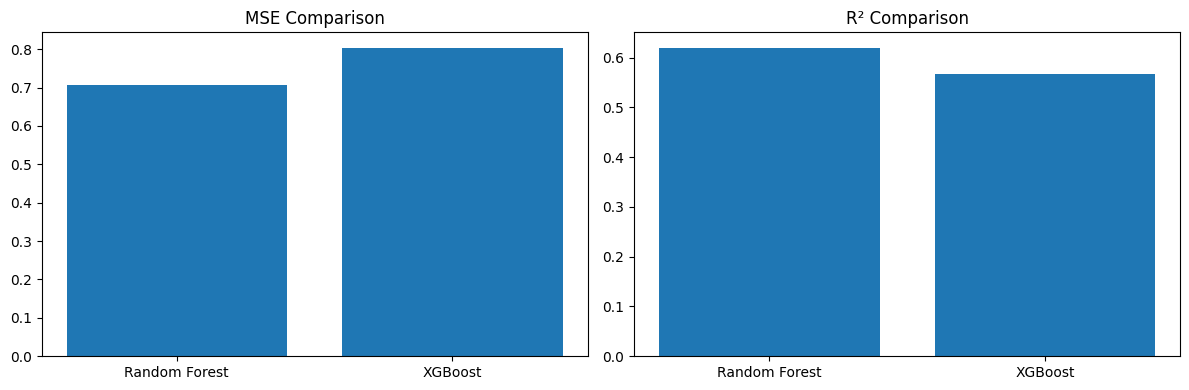

In [26]:
#9. Model Comparison Visualization
models = ['Random Forest', 'XGBoost']
mse_scores = [mse_rf, mse_xgb]
r2_scores  = [r2_rf, r2_xgb]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.bar(models, mse_scores)
plt.title('MSE Comparison')

plt.subplot(1,2,2)
plt.bar(models, r2_scores)
plt.title('R² Comparison')

plt.tight_layout()
plt.show()

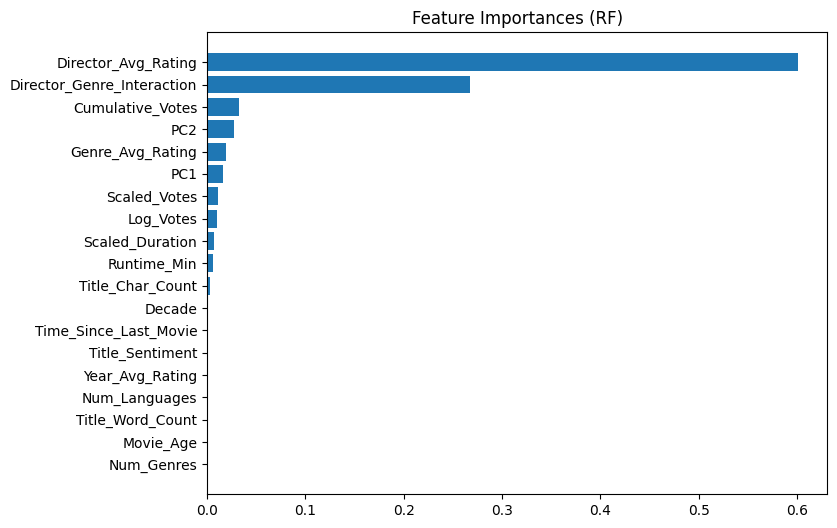

In [ ]:
#10. Feature Importance (Random Forest)
importances = best_rf.feature_importances_
idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(np.array(features)[idx], importances[idx])
plt.title('Feature Importances (RF)')
plt.show()